# Assignment 2

In this assignment we analyze the problematic described in a paper called:
    *Panning for Gold: Model-X Knockoffs for High-dimensional Controlled Variable Selection*.
    
The exercises in this assignment are given as follows:

1. Reproduce Figure 1 from the paper.
2. What is the problem that Figure 1 tries to illustrate?
3. Propose a solution to address the problem. You can implement conditional randomization test, another existing method or come up with your own idea.
4. Go back to Figure 1 and show that your solution fixes the problem.
5. Find a real dataset and apply your method.


## 1. Figure recreation
To reproduce the figure we have to identify the test setting they were using.
We look at a linear regression model, which is defined by the equation:
$Y = \beta_0 + \sum_{i=1}^p \beta_i X_i$, here: $\beta_0 = 0$
The $\beta_i$ are then the coefficients of the model and the $X_i$ are the input variables. They are modeled as an autoregressive model with the AR coefficient $0.5$. That means, $X_1 , \dots, X_p$ are defined by $X_t = 0.5 \cdot X_{t-1} + \epsilon_t$  

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as statm
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, LogisticRegression
from typing import Callable

from ipywidgets import IntProgress
from IPython.display import display

In [8]:
def generate_AR1s(n:int =500, p:int =200, coeff:float = 0.5):
    """
    The function generates nxp autoregressive values.
    :param n: number of time series to generate (samples)
    :param p: number of values per time series (predictors)
    :param coeff: coefficient of the autoregressive model
    :return: the genrated nxp matrix containing samples of autoregressive models
    """
    Xs = np.random.normal(0,1,size=(n,p)) # Here, Xs contains only the epsilons of the equation. The first entry is X_0.
    # Now we simulate the autoregressive model by adding for each column the previous value to the current value, which is only the epsilon.
    for k in range(1,p):
        Xs[:,k] = Xs[:,k] + coeff*Xs[:,k-1]
    return Xs

In [9]:
def generate_response(n:int = 500, prob:float|np.ndarray =0.5):
    """
    The function generates p responses using a bernoulli distribution.
    :param n: number of values to generate
    :param prob: probability or probabilities
    :return: the responses
    """
    y = np.zeros((n,))
    if type(prob) is float:
        y = np.random.binomial(1, prob, n)
    else:
        for i in range(n):
            y[i] = np.random.binomial(1, prob[i], 1)[0]
    return y

In [10]:
def get_single_logreg_p(n:int =500, p:int =200, coeff:float = 0.5, prob:float =0.5, mode:str = 'global'):
    """
    The function simulates one matrix with 500 time series with 200 points each. It fits a logistic regression model to it and calculates the p-values using bootstrapping.
    :param n: number of time series to generate (samples)
    :param p: number of values per time series (predictors)
    :param coeff: coefficient of the autoregressive model
    :param prob: probability or coefficient for logit probabilities
    :param mode: mode of test setting, if 
                'global' the global null distribution of the p-values is calculated using the given probability
                'nonzero' only 20 coefficients of the model are set to nonzero and the prob is the coefficient for the response calculated using the logit
    :return: the p-values
    """
    X = generate_AR1s(n=n, p=p, coeff=coeff)  # (500,200)
    if mode == 'global':
        Y = generate_response(n=n, prob=prob)  # (500,)
    elif mode == 'nonzero':
        non_zero_idcs = np.random.randint(1,p,20)  # Creates 20 indices for which the coefficients will be nonzero
        X_rel = X[:, non_zero_idcs] 
        probs = prob * np.sum(X_rel, axis=1)
        Y = generate_response(n=n, prob = 1 / (1 + np.exp(-probs)))
    logreg = statm.Logit(Y,X).fit(disp=0)
    return logreg.pvalues

In [11]:
def simulate_k_logreg(n:int =500, p:int =200, coeff:float = 0.5, prob:float =0.5, mode:str = 'global', k:int =10, beta_idx:int =0):
    """
    This function calls get_single_linreg_p() k times and returns the p values for the beta with index beta_idx.
    :param n: number of time series to generate (samples)
    :param p: number of values per time series (predictors)
    :param coeff: coefficient of the autoregressive model
    :param prob: probability or coefficient for logit probabilities
    :param k: number of replicates
    :param beta_idx: index of the coefficient for which the p-values are returned
    :param mode: mode of test setting, if 
                'global' the global null distribution of the p-values is calculated using the given probability
                'nonzero' only 20 coefficients of the model are set to nonzero and the prob is the coefficient for the response calculated using the logit
    :return: An array containing the p-values
    """
    p_vals = []
    f = IntProgress(min=0, max=k) # instantiate the bar
    display(f)
    for i in range(k):
        ps = get_single_logreg_p(n=n, p=p, coeff=coeff, prob=prob, mode=mode)
        p_vals.append(ps[beta_idx])
        f.value += 1
    return p_vals

In [12]:
def plot_histogram(p_vals:np.ndarray, title:str, x_label:str ="p-values", y_label:str = "count", bins:int =20):
    """
    This function creates a histogram for the given p-values with the defined number of bins.
    :param p_vals: np.array containing the p-values
    :param title: Title of the figure
    :param x_label: Label of the x-axis
    :param y_label: Label of the y-axis
    :param bins: number of bins to print
    """
    plt.figure()
    plt.hist(p_vals, bins = bins, edgecolor='black')
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()

### First part

IntProgress(value=0, max=10000)

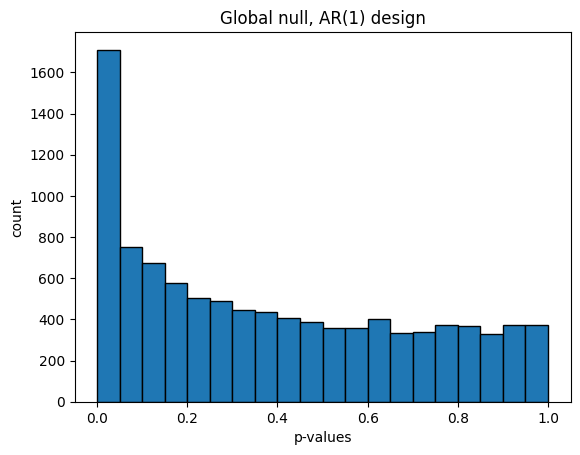

In [7]:
p_vals = simulate_k_logreg(k=10000)
plot_histogram(p_vals, title="Global null, AR(1) design")

### Second part

IntProgress(value=0, max=10000)

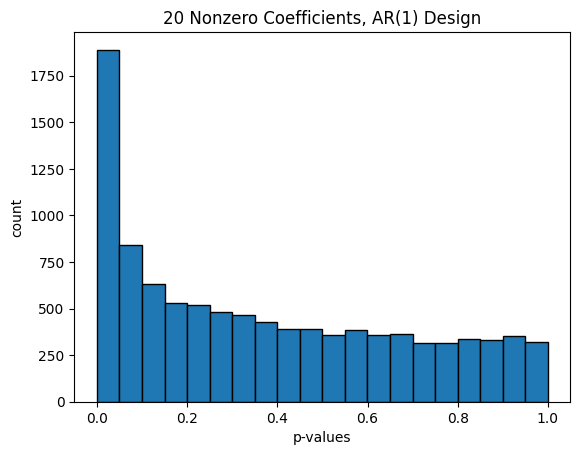

In [20]:
p_vals = simulate_k_logreg(mode='nonzero', prob=0.08, k=10000)
plot_histogram(p_vals, title="20 Nonzero Coefficients, AR(1) Design")

## 2. Illustrated Problem
The problem stated in the paper is about variable selection in the context of regression model. In high dimensionality, the response of the model is probably depending on a subset of the features. The goal is to remove the predictors which have no effect to the outcome. The determination of these features is challenging, especially when the number of predictors $p$ and the number of measurements $n$ are both large such that $p/n\geq 0.1$.
The figure visualizes this problem by showing a histogram of the p-values of $\beta_1$. We can see that in high-dimensional settings non-uniformity occurs in the null distribution of p-values. This non-uniformity can lead to challenges in accurately assessing the significance of variables and controlling the desired variable selection.

## 3. Proposed Solution
A solution proposed in the paper is the conditional randomization test as an alternative approach for a controlled variable selection.

In [2]:
def sample_cond_dist(X, j):
    """
    This function returns the data matrix X with a new jth column that is sampled from the conditional distribution of that row from the data without that row. For that we use the bootstrap method and resample the column..
    :param X: data 
    :param j: index of the resampled row
    :return: copy of X with the jth row replaced
    """
    X_repl = X.copy()
    new_X_j = np.random.choice(X[:, j], size=X.shape[0], replace=True)
    X_repl[:, j] = new_X_j
    return X_repl

In [3]:
def feature_importance_statistic(X, y, j):
    """
    Return the importance of the jth feature in X for the response y. We here use the Linear Regression Coefficient as indicator of the features importance.
    :param X: data
    :param y: response
    :param j: feature index
    :return: feature importance
    """
    model = LogisticRegression().fit(X, y)
    coef = model.coef_[0]
    return coef[j]

In [4]:
def conditional_rand_test(X:np.ndarray, y:np.ndarray, T:Callable, K:int, j:int):
    """
    This function performs a conditional randomization test on given input X and responses y, using the feature importance statistic T.
    :param X: n samples 
    :param y: n responses
    :param T: importance statistic
    :param K: number of permutations
    :param j: index of feature to analyze
    :return: a one-sided p-value for the jth predictor
    """
    importance_og = np.ones((K,)) * T(X, y, j)
    importances_repl = np.ones((K,))
    for k in range(K):
        X_repl = sample_cond_dist(X,j)
        importances_repl[k] = T(X_repl, y, j)
    is_greater = importances_repl >= importance_og
    p_val = (1 / (K+1)) * (1+np.sum(is_greater))
    return p_val
        

In [5]:
def get_single_condtest_p(n:int =500, p:int =200, coeff:float = 0.5, prob:float =0.5, mode:str = 'global', beta_idx:int = 0):
    """
    The function simulates one matrix with 500 time series with 200 points each. It fits a logistic regression model to it and calculates the p-values using bootstrapping.
    :param n: number of time series to generate (samples)
    :param p: number of values per time series (predictors)
    :param coeff: coefficient of the autoregressive model
    :param prob: probability or coefficient for logit probabilities
    :param beta_idx: index of the coefficient for which the p-values are returned
    :param mode: mode of test setting, if 
                'global' the global null distribution of the p-values is calculated using the given probability
                'nonzero' only 20 coefficients of the model are set to nonzero and the prob is the coefficient for the response calculated using the logit
    :return: the p-values
    """
    X = generate_AR1s(n=n, p=p, coeff=coeff)  # (500,200)
    if mode == 'global':
        Y = generate_response(n=n, prob=prob)  # (500,)
    elif mode == 'nonzero':
        non_zero_idcs = np.random.randint(1,p,20)  # Creates 20 indices for which the coefficients will be nonzero
        X_rel = X[:, non_zero_idcs] 
        probs = prob * np.sum(X_rel, axis=1)
        Y = generate_response(n=n, prob = 1 / (1 + np.exp(-probs)))
    p_val = conditional_rand_test(X, Y, feature_importance_statistic, 100, beta_idx)
    return p_val

In [6]:
def simulate_k_condtest(n:int =500, p:int =200, coeff:float = 0.5, prob:float =0.5, mode:str = 'global', k:int =10, beta_idx:int =0):
    """
    This function calls get_single_linreg_p() k times and returns the p values for the beta with index beta_idx.
    :param n: number of time series to generate (samples)
    :param p: number of values per time series (predictors)
    :param coeff: coefficient of the autoregressive model
    :param prob: probability or coefficient for logit probabilities
    :param mode: mode of test setting, if 
                'global' the global null distribution of the p-values is calculated using the given probability
                'nonzero' only 20 coefficients of the model are set to nonzero and the prob is the coefficient for the response calculated using the logit
    :param k: number of replicates
    :param beta_idx: index of the coefficient for which the p-values are returned
    :return: An array containing the p-values
    """
    p_vals = []
    f = IntProgress(min=0, max=k) # instantiate the bar
    display(f)
    for i in range(k):
        p_val = get_single_condtest_p(n=n, p=p, coeff=coeff, prob=prob, mode=mode, beta_idx=beta_idx)
        p_vals.append(p_val)
        f.value += 1
    return p_vals

## 4. Plotted solution 

IntProgress(value=0, max=1000)

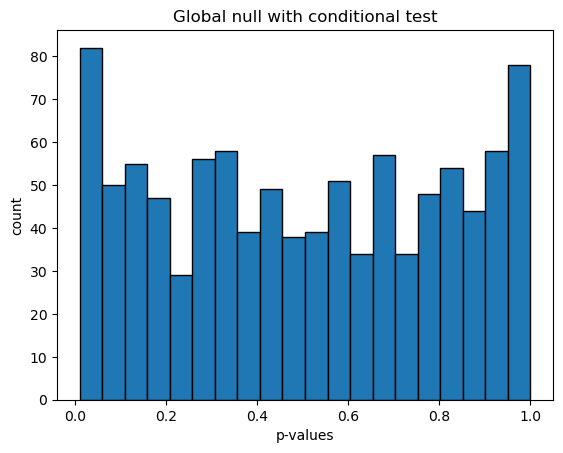

In [12]:
p_vals = simulate_k_condtest(k=1000)
plot_histogram(p_vals, title="Global null with conditional test")

IntProgress(value=0, max=10000)

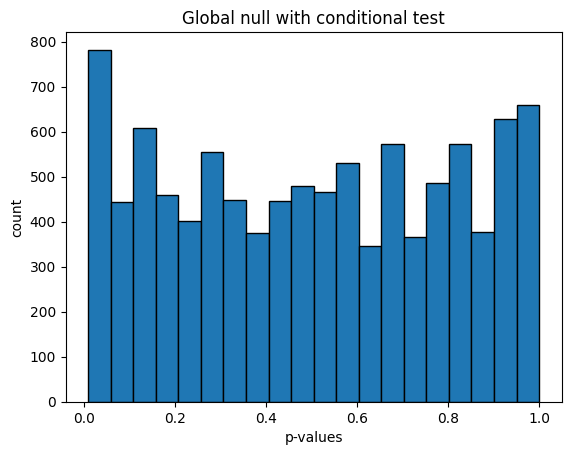

In [13]:
p_vals = simulate_k_condtest(k=10000)
plot_histogram(p_vals, title="Global null with conditional test")
# sadly no time for 10k

In [ ]:
p_vals = simulate_k_condtest(mode='nonzero', prob=0.08, k=10000)
plot_histogram(p_vals, title="20 Nonzero Coefficients, conditional test")

IntProgress(value=0, max=10000)

IntProgress(value=0, max=1000)

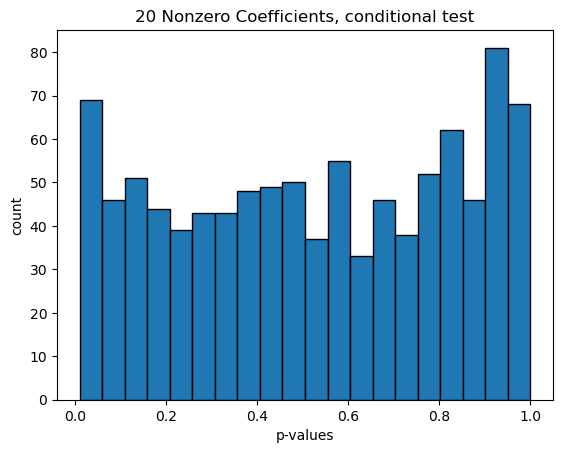

In [20]:
p_vals = simulate_k_condtest(mode='nonzero', prob=0.08, k=1000)
plot_histogram(p_vals, title="20 Nonzero Coefficients, conditional test")

## 5. Real Dataset 
We are going to use the boston housing dataset to apply the conditional randomization test.

In [ ]:
genes_names = pd.read_csv("data/genes.csv")
labels = np.load("data/y.npy")
DataMatrix = np.load("data/X.npy")

In [ ]:
p_val1 = conditional_rand_test(DataMatrix, labels, feature_importance_statistic, 10, 1) # calculate p-value with the conditional randomization test for the first 
p_val2 = conditional_rand_test(DataMatrix, labels, feature_importance_statistic, 10, 2) # calculate p-value with the conditional randomization test for the first 
p_val3 = conditional_rand_test(DataMatrix, labels, feature_importance_statistic, 10, 3) # calculate p-value with the conditional randomization test for the first 

In [19]:
print(f"{p_val1=}")
print(f"{p_val2=}")
print(f"{p_val3=}")

p_val1=0.09090909090909091
p_val2=0.4545454545454546
p_val3=0.5454545454545454
